# Learning a latent manifold on a noisy swiss roll

## Data set definition

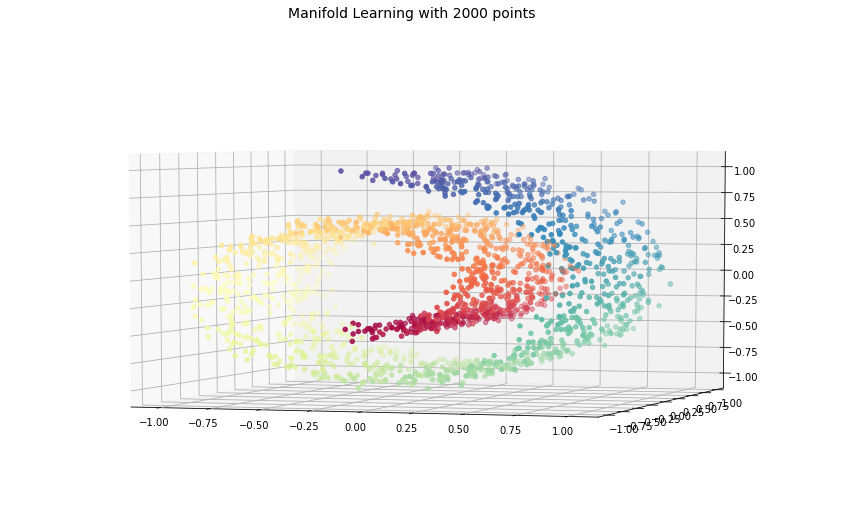

In [140]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn.preprocessing as preprocessing
from sklearn import datasets
import numpy as np
import fnmatch

# Get scaled data set wrt. to the data set (X_aux) for the shortest-path proxy
n_aux_points = 5000
n_points = 5000
X_aux, _ = datasets.samples_generator.make_swiss_roll(n_aux_points, random_state=0, noise=0.7)
X, color = datasets.samples_generator.make_swiss_roll(n_points, random_state=0, noise=0.5)
X = np.concatenate((X_aux, X), axis=0)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0., 1.))
X = min_max_scaler.fit_transform(X)[n_aux_points:,:]

fig = plt.figure(figsize=(15, 15), dpi=150)
plt.suptitle("Manifold Learning with %i points"% (n_points), fontsize=14)

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
plt.show()

## Define the VAE with its perceptual loss

python version:  3.5.2
keras version: 2.3.0
tensorflow version: 1.14.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available
tracking <tf.Variable 'Variable_74:0' shape=() dtype=float32> weight
tracking <tf.Variable 'Variable_75:0' shape=() dtype=float32> weight
Epoch 1/50
 - 1s - loss: 450.8560
Epoch 2/50
 - 0s - loss: 312.9114
Epoch 3/50
 - 0s - loss: 296.3598
Epoch 4/50
 - 0s - loss: 274.9930
Epoch 5/50
 - 0s - loss: 252.4894
Epoch 6/50
 - 0s - loss: 234.9655
Epoch 7/50
 - 0s - loss: 198.8521
Epoch 8/50
 - 0s - loss: 188.7515
Epoch 9/50
 - 0s - loss: 182.1175
Epoch 10/50
 - 0s - loss: 175.9138
Epoch 11/50
 - 0s - loss: 169.4308
Epoch 12/50
 - 0s - loss: 163.1546
Epoch 13/50
 - 0s - loss: 164.5280
Epoch 14/50
 - 0s - loss: 158.5152
Epoch 15/50
 - 0s - loss: 154.9097
Epoch 16/50
 - 0s - loss: 155.9032
Epoch 17/50
 - 0s - loss: 154.3097
Epoch 18/50
 - 0s - loss: 151.0936
Epoch 19/50
 - 0s - loss: 147.0067
Epoch 20/50
 - 0s - loss: 148.3448
Epoch 21/50
 - 0s - loss

/usr/local/lib/python3.5/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output loss_reconstruction_0_0 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to loss_reconstruction_0_0.
  'be expecting any data to be passed to {0}.'.format(name))
/usr/local/lib/python3.5/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output loss_prior_0 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to loss_prior_0.
  'be expecting any data to be passed to {0}.'.format(name))


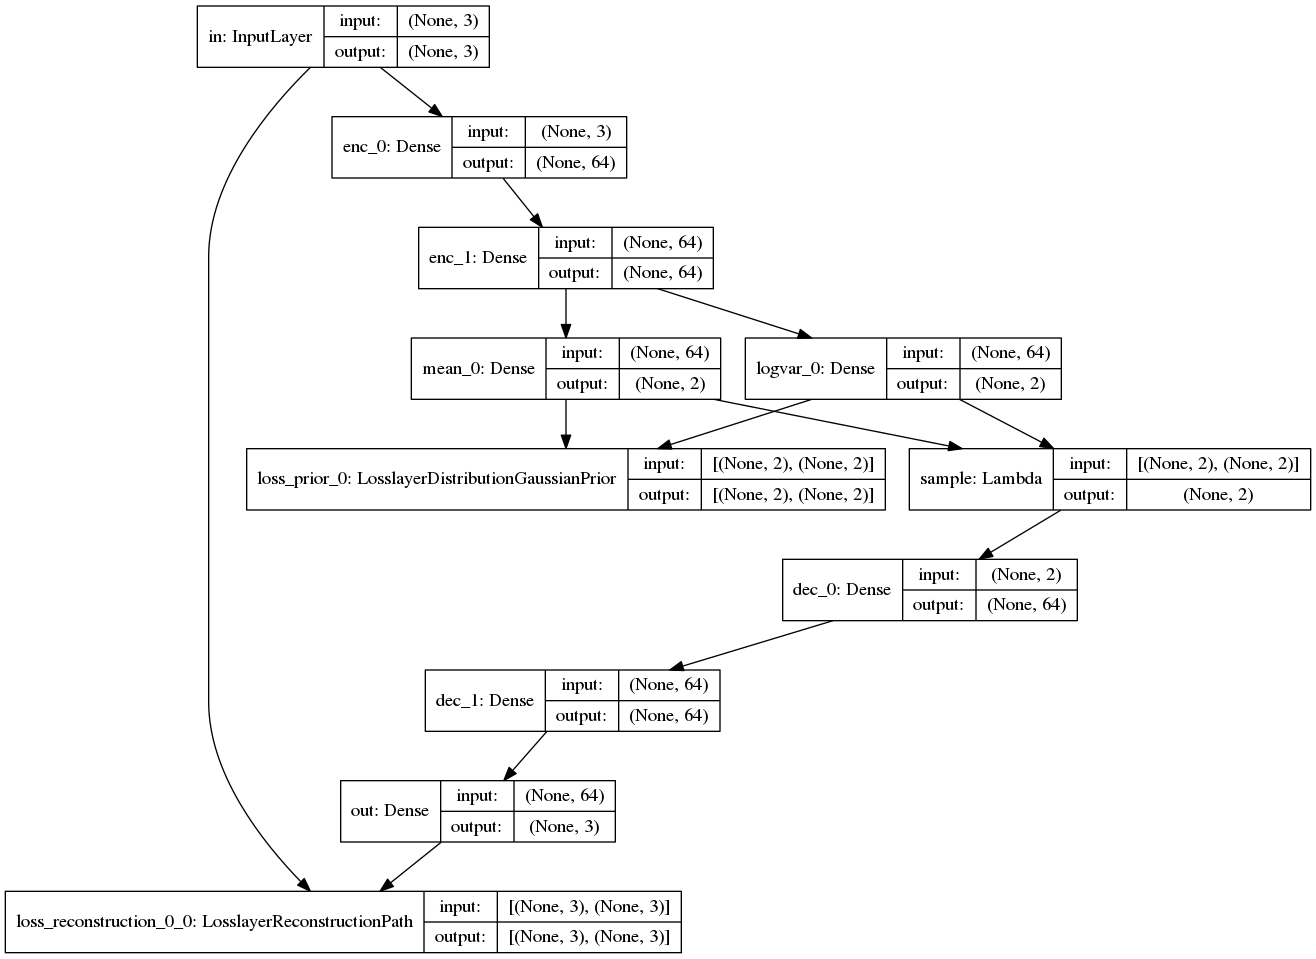

In [141]:
# Disable graphic card
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import vae_tools.sanity
import vae_tools.viz
import vae_tools.vae
import vae_tools.callbacks
import keras.backend as K
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
from keras.layers import Input, Dense
import tensorflow as tf
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
from keras.models import load_model
from keras import metrics

z_dim = 2
intermediate_dim = 64
beta = 10.
epochs = 10000
batch_size = 64
weight = 12.
weight_mse = 6.

## Defining the geodesic (aka perceptual) loss

The following def. is what we actually want to do: Defining a loss by a shortest-path algorithm.
However, this does not work since we cannot backprop through that kind of approach.

Using a shortest-path proxy by means of a neuronal network does work.
Because now we can backprop the resulting gradient through this network.

In [ ]:
class LosslayerReconstructionPath(vae_tools.vae.LosslayerReconstruction):
    '''Loss layer for element-wise path distance'''

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.model = load_model('models/shortest_path_predictor_0to1.h5')
        self.model.trainable = False
        
    def get_sample(self, x_1, x_2): 
        x = tf.concat([x_1, x_2], axis=1)
        return x
    
    def get_distance(self, x, x_decoded):
        x_input = self.get_sample(x, x_decoded)
        dist = self.model(x_input)
        return dist
    
    def get_mse(self, x, x_decoded):
        x_input = self.get_sample(x, x_decoded)
        dist = self.model(x_input)
        return dist
    
    def metric(self, inputs):
        return K.sum(self.weight * (self.get_distance(inputs[0], inputs[1]))) + K.sum(weight_mse * metrics.mean_squared_error(inputs[0], inputs[1]))

encoder = [[
    Input(shape=(3,), name="in"),
    Dense(intermediate_dim, activation='elu', name="enc_0"),
    Dense(int(intermediate_dim/2), activation='elu', name="enc_1")
]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='elu', name="dec_0"),
    Dense(intermediate_dim, activation='elu', name="dec_1"),
    Dense(3, activation='linear', name="out")
]]

model_name = "geodesic_vae"

vae_obj = MmVae(z_dim, encoder, decoder, [weight], 
                beta, beta_is_normalized = False,
                reconstruction_loss_metrics = [LosslayerReconstructionPath], name=model_name)

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = False)

In [ ]:
# Train the network
vae.fit(X, shuffle=True, epochs=epochs, batch_size=batch_size,
        validation_data=None, verbose = 0)
# Show the losses
#vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)

## Show the resulting latent space

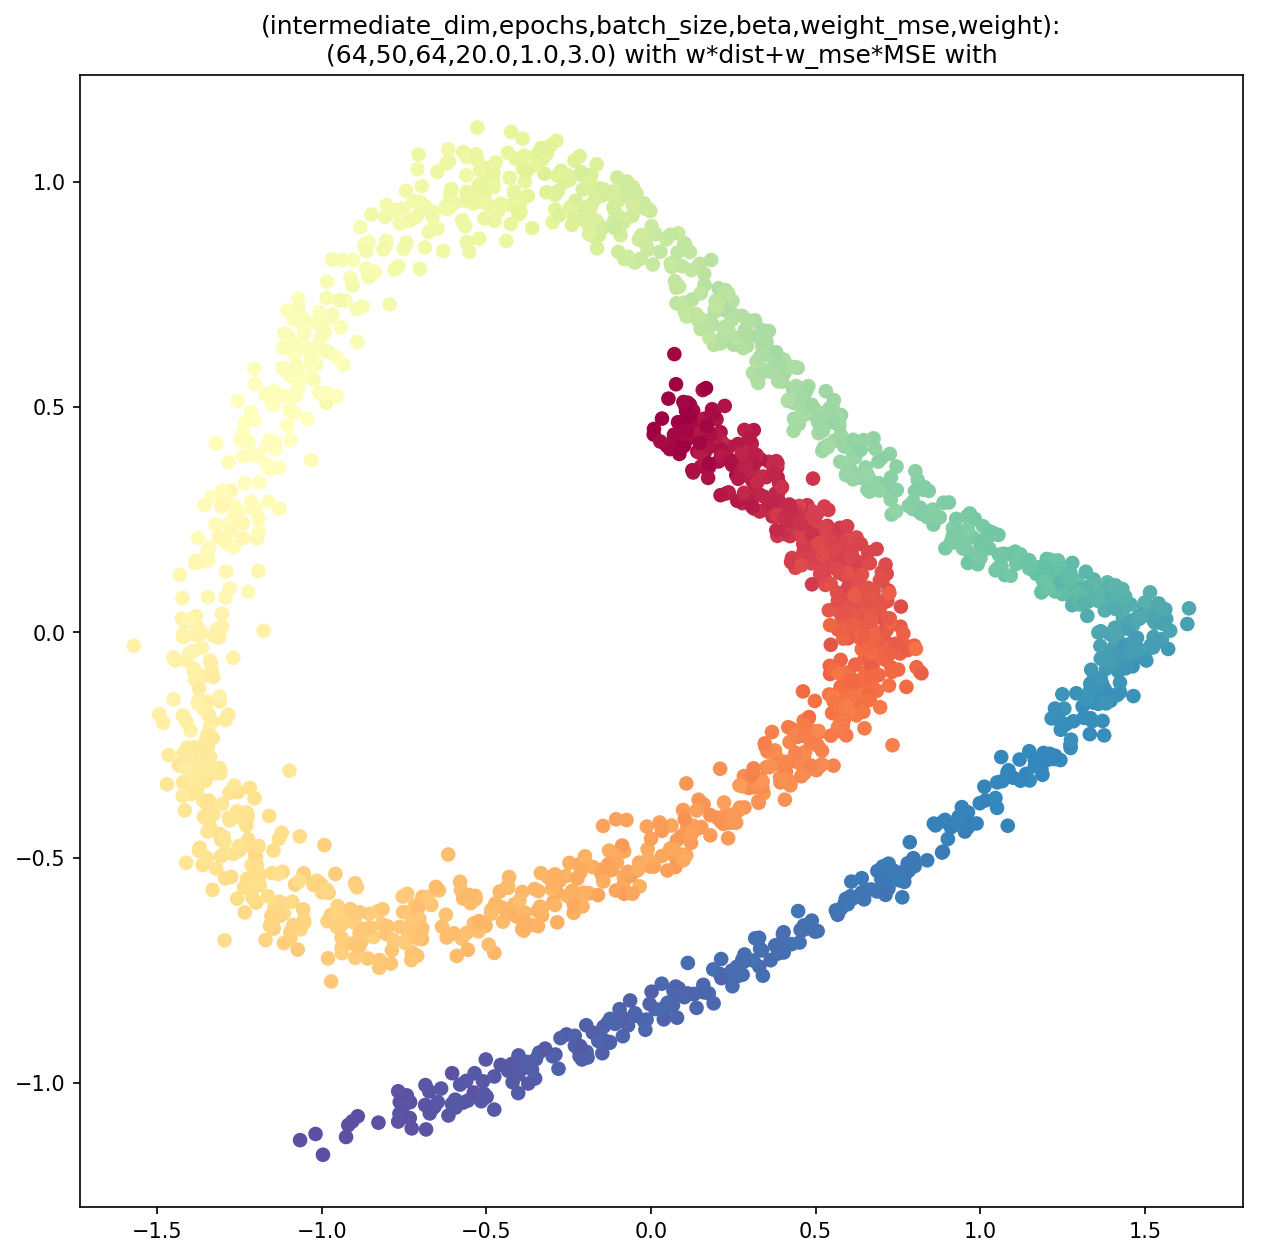

In [146]:
vae_enc = vae_obj.get_encoder_mean([encoder[0][0]])
x_enc = vae_enc.predict(X)

f, ax = plt.subplots(1,1,figsize=(10, 10), dpi=150)
ax.scatter(x_enc[:,0], x_enc[:,1], c=color, cmap=plt.cm.Spectral)
plt.title("(intermediate_dim,epochs,batch_size,beta,weight_mse,weight):\n (%i,%i,%i,%.1f,%.1f,%.1f) with w*dist+w_mse*MSE with "% (intermediate_dim,epochs,batch_size,beta,weight_mse,weight))

#plt.savefig('_' + str(len(fnmatch.filter(os.listdir("."), '*.png'))) + '.png')
plt.show()